<a href="https://colab.research.google.com/github/sandrarajp/Amazon-commerce-reviews/blob/main/ml_assignment_amz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IMPORTS
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
#MODEL CLASS DEFINITIONS Perceptron
class Perceptron:
    """
    Perceptron linear classifier implemented from scratch using NumPy.
    Uses an update rule based on individual misclassified samples.
    """
    def __init__(self, learning_rate=0.01, n_iterations=50):
        self.lr = learning_rate
        self.n_iters = n_iterations
        self.weights = None

    def _unit_step_func(self, x):
        """Activation function: Returns 1 if x >= 0, else 0."""
        return np.where(x >= 0, 1, 0)

    def fit(self, X, y):
        """Trains the Perceptron model using a sample-based update rule.
        Accepts y as shape (m,) or (m,1)"""
        n_features = X.shape[1]
        self.weights = np.zeros((n_features, 1))

        # Ensure y is 1D for indexing
        y_flat = y.flatten()

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                x_i_col = x_i.reshape(-1, 1)   # (n_features, 1)
                linear_output = float(np.dot(x_i_col.T, self.weights))  # scalar
                prediction = int(self._unit_step_func(linear_output))  # 0 or 1
                y_i = int(y_flat[idx])  # true label scalar

                update = self.lr * (y_i - prediction)  # scalar
                # weight update (broadcast)
                self.weights += update * x_i_col

    def predict(self, X):
        linear_output = np.dot(X, self.weights)
        return self._unit_step_func(linear_output).astype(int).flatten()

In [3]:
#ScratchLogisticRegression
class ScratchLogisticRegression:
    """
    Logistic Regression implemented from scratch using NumPy.
    Trained using vectorized Batch Gradient Descent.
    """
    def sigmoid(self, z):
        z = np.clip(z, -500, 500)  # Numerical stability
        return 1 / (1 + np.exp(-z))

    def calculate_loss(self, h, y):
        """Binary cross-entropy"""
        m = y.shape[0]
        h = np.clip(h, 1e-15, 1 - 1e-15)
        cost = (-1 / m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        return cost

    def fit(self, X, y, learning_rate=0.01, epochs=10000, verbose=True):
        m, n = X.shape
        # Ensure y shape is (m,1)
        y_col = y.reshape(-1, 1)
        self.weights = np.zeros((n, 1))
        self.loss_history = []

        if verbose:
            print("Training Scratch Logistic Regression...")
        for epoch in range(epochs):
            z = X @ self.weights                # (m,1)
            h = self.sigmoid(z)                 # (m,1)
            error = h - y_col                   # (m,1)
            gradient = (X.T @ error) / m        # (n,1)
            self.weights -= learning_rate * gradient
            loss = self.calculate_loss(h, y_col)
            self.loss_history.append(loss)
            if verbose and epoch % max(1, epochs // 10) == 0:
                print(f"Epoch {epoch:5d}, Cost: {loss:.6f}")

    def predict(self, X, threshold=0.5):
        probs = self.sigmoid(X @ self.weights)
        return (probs >= threshold).astype(int).flatten()

In [4]:
#SimpleNN
class SimpleNN:
    """
    Simple Neural Network with one hidden layer, trained using Backpropagation.
    Sigmoid activations for hidden and output layers (binary classification).
    """
    def __init__(self, input_size, hidden_size, output_size=1, learning_rate=0.05, n_iterations=5000, verbose=True):
        self.lr = learning_rate
        self.n_iters = n_iterations
        self.verbose = verbose

        # small random init
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        self.loss_history = []

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def _sigmoid_derivative(self, A):
        return A * (1 - A)

    def _calculate_loss(self, A2, y):
        m = y.shape[0]
        A2 = np.clip(A2, 1e-15, 1 - 1e-15)
        cost = (-1 / m) * np.sum(y * np.log(A2) + (1 - y) * np.log(1 - A2))
        return cost

    def fit(self, X, y):
        m = X.shape[0]
        y_col = y.reshape(-1, 1)
        for epoch in range(self.n_iters):
            # forward
            Z1 = np.dot(X, self.W1) + self.b1
            A1 = self._sigmoid(Z1)
            Z2 = np.dot(A1, self.W2) + self.b2
            A2 = self._sigmoid(Z2)
            # backprop
            dZ2 = A2 - y_col
            dW2 = (1 / m) * np.dot(A1.T, dZ2)
            db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True)
            dZ1 = np.dot(dZ2, self.W2.T) * self._sigmoid_derivative(A1)
            dW1 = (1 / m) * np.dot(X.T, dZ1)
            db1 = (1 / m) * np.sum(dZ1, axis=0, keepdims=True)
            # update
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
            # loss
            loss = self._calculate_loss(A2, y_col)
            self.loss_history.append(loss)
            if self.verbose and epoch % max(1, self.n_iters // 10) == 0:
                print(f"Epoch {epoch:5d}, Cost: {loss:.6f}")

    def predict(self, X):
        Z1 = np.dot(X, self.W1) + self.b1
        A1 = self._sigmoid(Z1)
        Z2 = np.dot(A1, self.W2) + self.b2
        A2 = self._sigmoid(Z2)
        preds = (A2 >= 0.5).astype(int)
        return preds.flatten()


In [5]:
# Cell 3: HELPERS & CONFIG
def calculate_accuracy(y_true, y_pred):
    return np.sum(y_true.flatten() == y_pred.flatten()) / len(y_true)

# Set these before running
FILE_NAME = r"Amazon_dataset.csv"   # <-- replace with full path if needed
TARGET_AUTHOR = "Agresti"          # <-- change to test other authors
K_FEATURES = 100                   # desired top-k features (SelectKBest)
RANDOM_STATE = 42

print("Config ready. FILE_NAME:", FILE_NAME)

Config ready. FILE_NAME: Amazon_dataset.csv


In [10]:
# Cell 4: LOAD DATA & SANITY CHECKS

FILE_NAME = r"/content/Amazon_dataset.csv"

import os

if not os.path.exists(FILE_NAME):
    raise FileNotFoundError(f"File not found: {FILE_NAME}\nPlease check the path and try again.")

df = pd.read_csv(FILE_NAME)
print("Dataset shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

if 'class_1' not in df.columns:
    raise KeyError("Expected 'class_1' column in dataframe. Please confirm the target column name.")

authors = df['class_1'].unique()
print("\nNumber of unique authors:", len(authors))
print("Some authors (first 30):", authors[:30])

TARGET_AUTHOR = "Agresti"
n_pos = int(np.sum(df['class_1'] == TARGET_AUTHOR))
n_total = len(df)
print(f"\nTARGET_AUTHOR = '{TARGET_AUTHOR}'  --> {n_pos} positive samples out of {n_total} ({n_pos/n_total:.3%})")


Dataset shape: (915, 10001)

Columns:
 ['the', 'and', 'a', 'of', 'to', 'is', 'I', 'in', 'that', 'it', 'for', 'this', 's', 'with', 'The', 'you', 'as', 'are', 'on', 'have', 'but', 'book', 'was', 'be', 'not', 'one', 'an', 't', 'from', 'my', 'at', 'or', 'his', 'by', 'so', 'It', 'can', 'has', 'This', 'more', 'all', 'her', 'they', 'about', 'who', 'will', 'up', 'some', 'like', 'which', 'very', 'your', 'out', 'also', 'well', 'he', 'if', 'than', 'when', 'good', 'them', 'other', 'get', 'there', 'just', 'their', 'time', 'into', 'these', 'would', 'only', 'me', 'use', 'much', 'what', 'do', 'story', 'how', 'had', 'many', 'most', 'even', 'she', 'been', 'no', 'first', 'great', 'we', 'In', 'work', 'If', 'really', 'two', 'its', 'life', 'make', 'There', 'were', 'A', 'because', 'way', 'read', 'those', 'little', 'find', 'film', 'does', 'don', 'any', 'people', 'too', 'love', 'best', 'over', 'through', 'new', 'then', 'own', 'such', 'may', 'want', 'could', 'years', 'set', 've', 'being', 'But', 'back', 'better

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.impute import SimpleImputer
import numpy as np

# 1) Convert X to numeric
X_numeric = X_df.apply(pd.to_numeric, errors='coerce')
print("Raw X shape:", X_numeric.shape)
print("Number of NaNs in raw X:", X_numeric.isna().sum().sum())

# 2) Impute NaNs with column mean
imputer = SimpleImputer(strategy='mean')
X_filled = imputer.fit_transform(X_numeric)
print("After imputing NaNs:", X_filled.shape)
print("Any NaNs left:", np.isnan(X_filled).any())

# 3) Variance Threshold
var_thresh = VarianceThreshold(threshold=0.01)
X_var = var_thresh.fit_transform(X_filled)
print("After VarianceThreshold:", X_var.shape)

# 4) Force numeric and finite
X_var = np.nan_to_num(X_var.astype(float))
print("After forcing finite float values:", X_var.shape)
print("Any NaNs left:", np.isnan(X_var).any())

# 5) Encode y as integers for SelectKBest
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # y_encoded is numeric
print("y_encoded shape:", y_encoded.shape)

# 6) SelectKBest
k = min(K_FEATURES, X_var.shape[1])
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X_var, y_encoded)
print(f"After SelectKBest (k={k}):", X_selected.shape)

# 7) Binary target (one-vs-all)
y_binary = (y == TARGET_AUTHOR).astype(int).reshape(-1, 1)
print("Binary target shape:", y_binary.shape)

# 8) Add bias column
X_b = np.c_[np.ones((X_selected.shape[0], 1)), X_selected]
print("Final X_b shape (with bias):", X_b.shape)


Raw X shape: (915, 10000)
Number of NaNs in raw X: 8702
After imputing NaNs: (915, 10000)
Any NaNs left: False
After VarianceThreshold: (915, 8283)
After forcing finite float values: (915, 8283)
Any NaNs left: False
y_encoded shape: (915,)
After SelectKBest (k=100): (915, 100)
Binary target shape: (915, 1)
Final X_b shape (with bias): (915, 101)


In [19]:
# Cell 6: TRAIN / TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X_b, y_binary, test_size=0.2, random_state=RANDOM_STATE, stratify=y_binary
)

print("Training set shape:", X_train.shape, "Test set shape:", X_test.shape)
print("Positive samples in train/test:", np.sum(y_train==1), np.sum(y_test==1))

Training set shape: (732, 101) Test set shape: (183, 101)
Positive samples in train/test: 24 6


In [20]:
# Cell 7: TRAIN & EVALUATE PERCEPTRON
print("\n--- Testing Perceptron ---")
p_model = Perceptron(learning_rate=0.01, n_iterations=100)
p_model.fit(X_train, y_train)
p_preds = p_model.predict(X_test)
p_acc = calculate_accuracy(y_test, p_preds)
print(f"Perceptron Accuracy: {p_acc:.4f}")
print("Perceptron Classification Report:\n", classification_report(y_test, p_preds, zero_division=0))
cm = confusion_matrix(y_test, p_preds)
print("Confusion Matrix:\n", cm)



--- Testing Perceptron ---


/tmp/ipython-input-308877044.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  linear_output = float(np.dot(x_i_col.T, self.weights))  # scalar


Perceptron Accuracy: 0.9727
Perceptron Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       177
           1       0.56      0.83      0.67         6

    accuracy                           0.97       183
   macro avg       0.77      0.91      0.83       183
weighted avg       0.98      0.97      0.98       183

Confusion Matrix:
 [[173   4]
 [  1   5]]


In [21]:
# Cell 8: TRAIN & EVALUATE SCRATCH LOGISTIC REGRESSION
print("\n--- Testing Logistic Regression ---")
lr_model = ScratchLogisticRegression()
# reduce epochs if it runs too long, e.g., epochs=3000
lr_model.fit(X_train, y_train, learning_rate=0.01, epochs=5000, verbose=True)
lr_preds = lr_model.predict(X_test)
lr_acc = calculate_accuracy(y_test, lr_preds)
print(f"Logistic Regression Accuracy: {lr_acc:.4f}")
print("Logistic Regression Classification Report:\n", classification_report(y_test, lr_preds, zero_division=0))
cm_lr = confusion_matrix(y_test, lr_preds)
print("Confusion Matrix (LR):\n", cm_lr)


--- Testing Logistic Regression ---
Training Scratch Logistic Regression...
Epoch     0, Cost: 0.693147
Epoch   500, Cost: 0.099649
Epoch  1000, Cost: 0.087423
Epoch  1500, Cost: 0.080172
Epoch  2000, Cost: 0.075053
Epoch  2500, Cost: 0.071144
Epoch  3000, Cost: 0.068008
Epoch  3500, Cost: 0.065405
Epoch  4000, Cost: 0.063186
Epoch  4500, Cost: 0.061255
Logistic Regression Accuracy: 0.9781
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       177
           1       1.00      0.33      0.50         6

    accuracy                           0.98       183
   macro avg       0.99      0.67      0.74       183
weighted avg       0.98      0.98      0.97       183

Confusion Matrix (LR):
 [[177   0]
 [  4   2]]


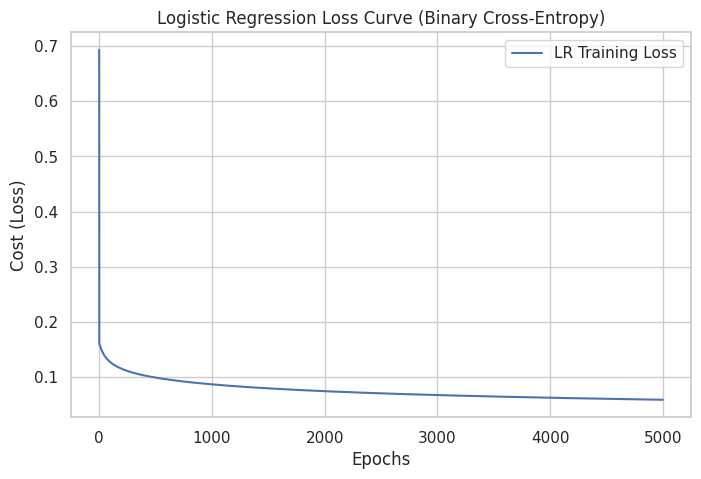

In [22]:
# Cell 9: PLOT LR LOSS CURVE
plt.figure(figsize=(8,5))
plt.plot(range(len(lr_model.loss_history)), lr_model.loss_history, label='LR Training Loss')
plt.title('Logistic Regression Loss Curve (Binary Cross-Entropy)')
plt.xlabel('Epochs')
plt.ylabel('Cost (Loss)')
plt.grid(True)
plt.legend()
plt.show()


In [23]:
# Cell 10: TRAIN & EVALUATE SIMPLE NEURAL NETWORK
print("\n--- Testing Simple Neural Network ---")
INPUT_SIZE = X_train.shape[1]
HIDDEN_SIZE = 8        # you can increase or decrease
NN_EPOCHS = 3000       # reduce if training is slow
nn_model = SimpleNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, learning_rate=0.1, n_iterations=NN_EPOCHS, verbose=True)
nn_model.fit(X_train, y_train)
nn_preds = nn_model.predict(X_test)
nn_acc = calculate_accuracy(y_test, nn_preds)
print(f"Simple NN Accuracy: {nn_acc:.4f}")
print("Simple NN Classification Report:\n", classification_report(y_test, nn_preds, zero_division=0))
cm_nn = confusion_matrix(y_test, nn_preds)
print("Confusion Matrix (NN):\n", cm_nn)



--- Testing Simple Neural Network ---
Epoch     0, Cost: 0.683689
Epoch   300, Cost: 0.118692
Epoch   600, Cost: 0.086014
Epoch   900, Cost: 0.075357
Epoch  1200, Cost: 0.068603
Epoch  1500, Cost: 0.063059
Epoch  1800, Cost: 0.057805
Epoch  2100, Cost: 0.052636
Epoch  2400, Cost: 0.047644
Epoch  2700, Cost: 0.042998
Simple NN Accuracy: 0.9781
Simple NN Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       177
           1       1.00      0.33      0.50         6

    accuracy                           0.98       183
   macro avg       0.99      0.67      0.74       183
weighted avg       0.98      0.98      0.97       183

Confusion Matrix (NN):
 [[177   0]
 [  4   2]]


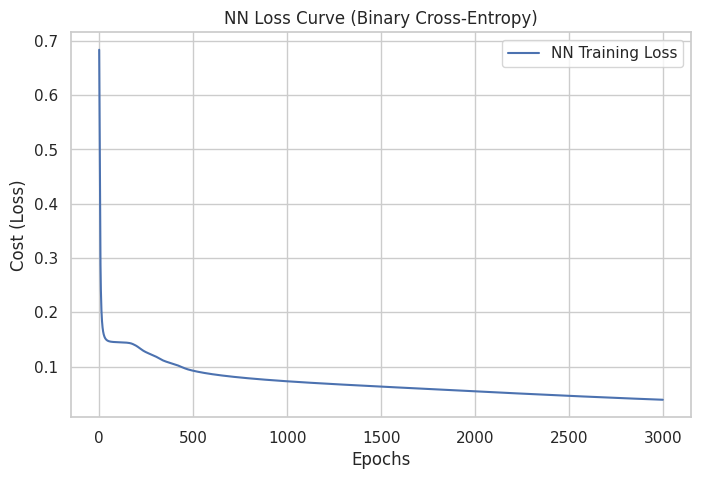


Model performance summary:
                Model  Accuracy
0          Perceptron  0.972678
1  LogisticRegression  0.978142
2            SimpleNN  0.978142


In [24]:
# Cell 11: PLOT NN LOSS CURVE
plt.figure(figsize=(8,5))
plt.plot(range(len(nn_model.loss_history)), nn_model.loss_history, label='NN Training Loss')
plt.title('NN Loss Curve (Binary Cross-Entropy)')
plt.xlabel('Epochs')
plt.ylabel('Cost (Loss)')
plt.grid(True)
plt.legend()
plt.show()

# Quick summary table
summary = {
    'Model': ['Perceptron', 'LogisticRegression', 'SimpleNN'],
    'Accuracy': [p_acc, lr_acc, nn_acc]
}
summary_df = pd.DataFrame(summary)
print("\nModel performance summary:")
print(summary_df)
